# Running a Single Fit with Manually-set Priors


In this example, we will show how to use builtin functions in `pysersic` as well as `numpyro.distributions` directly in order to set up your own priors for a fit. As a reminder, the `autoprior()` function is a good starting place. If you find it is not doing a good job estimating for your source or if  have extra knowledge you want add to the prior then you are in the right place!

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


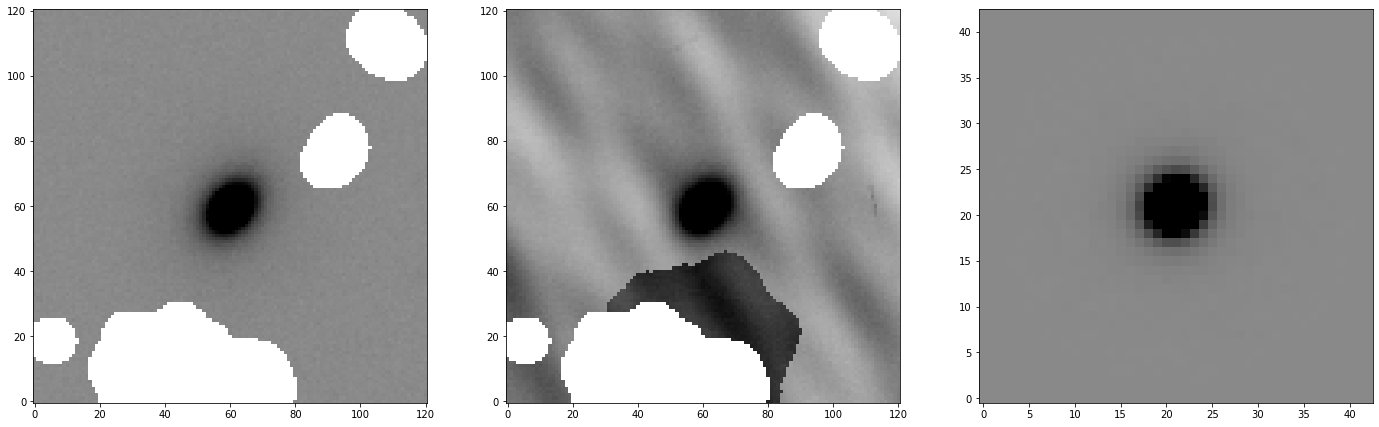

In [1]:
import numpy as np 
def load_data(n):
    im = np.load(f'examp_gals/gal{n}_im.npy')
    mask = np.load(f'examp_gals/gal{n}_mask.npy')
    sig = np.load(f'examp_gals/gal{n}_sig.npy')
    psf = np.load(f'examp_gals/gal{n}_psf.npy')
    return im,mask,sig,psf 

im,mask,sig,psf = load_data(2)

from pysersic.results import plot_image

fig, ax = plot_image(im,mask,sig,psf)

To begin, let's go ahead and use the `SourceProperties` to get a good start-point estimate to build off of:

In [2]:
from pysersic.priors import SourceProperties

props = SourceProperties(image = im,mask=mask)
prior_default = props.generate_prior('sersic', sky_type='none')
print(prior_default)

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00

Sky Type: none



On a sidenote the `VonMises` prior you see for theta is a there as it seamlessly wraps around from 2 $\pi$ to 0, avoiding convergence issues for galaxies with a position angle near this limit

These two lines of code are exactly what are contained in the autoprior function. Pretty simple right? The sourceProperties class has a built in function to use `photutils` to try to measure the source properties. Lets use the `.visualize` function to see how it did:

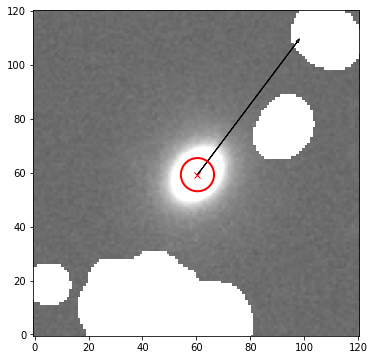

In [3]:
props.visualize();

In this figure the x marks the estimate center the arrow marks the direction of the position angle and the size of the red circle shows the estimated effective radius. We can see in this case that the initial guesses did a pretty good job.

Now lets say you have insider knowledge that the flux of this objects is about 4000 in the units of the image and you want to make sure to set that directly. Using the source properties class you can using the set_flux guess function, we will also specify the width of the flux prior. Then we call `generate_prior()` on source properties again to make a new prior

In [4]:
props.set_flux_guess(flux_guess=4000., flux_guess_err= 250.)
prior_w_flux = props.generate_prior('sersic')
print(prior_w_flux)

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 4000.00, sigma = 250.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00

Sky Type: none



There are also functions to easily adjust the r_eff, position and theta guesses built into the SourceProperties class to help make adjustments to these parameters

What if we want a little more direct control? For example lets say we don't like the Gaussian priors and want something less informative. In pysersic we can build a totally custom prior if we want to! We could also just build off of the prior we made above too if that is easier. We will also fit a flat sky background this time too!

First we will initialize a PySersicSourcePrior class. To do this we need to estimate the sky level, we will use the `estimate` sky function.

In [5]:
from pysersic.priors import PySersicSourcePrior, estimate_sky

sky_med, sky_std, n_pix = estimate_sky(image=im, mask = mask)
print (f"Median sky value: {sky_med:.3f}, with a scatter of {sky_std:.3f}")
sky_med_unc = sky_std/np.sqrt(n_pix) # Error on the median sky estimate

custom_prior = PySersicSourcePrior(profile_type='sersic', sky_type= 'flat', sky_guess=sky_med, sky_guess_err= 2*sky_med_unc)

Median sky value: 0.022, with a scatter of 0.067


In order for everything to go right we need to make sure we have priors for all the sources. At any point we can use the `prior.check_vars()` function to see if this is the case. Since we have not added priors for any of the variables yet this will result in `False`

In [6]:
custom_prior.check_vars(verbose=True)

Missing params for profile:  ['xc', 'yc', 'flux', 'r_eff', 'n', 'ellip', 'theta']
Extra params, will not be used:  []


False

To set a prior for a variable, we will invoke one of several methods known to our prior object:

- `prior.set_gaussian_prior()`,
- `prior.set_uniform_prior()`,
- `prior.set_truncated_gaussian_prior()`,
- `prior.set_custom_prior()`.

The final instance of this list is different than the others, and allows us to insert arbitrary `numpyro.distributions`. For this example we will be going with all uniform priors however

In [7]:
help(custom_prior.set_uniform_prior)

Help on method set_uniform_prior in module pysersic.priors:

set_uniform_prior(var_name: 'str', low: 'float', high: 'float') -> "'PySersicSourcePrior'" method of pysersic.priors.PySersicSourcePrior instance
    Set a uniform prior for a variable
    
    Parameters
    ----------
    var_name : str
        variable name
    low : float
        lower bound
    high : float
        upper bound
    
    Returns
    -------
    PySersicSourcePrior
        returns self to allow chaining



In [8]:
custom_prior.set_uniform_prior('xc', 55.,65.)
custom_prior.set_uniform_prior('yc', 55.,65.)
custom_prior.set_uniform_prior('flux', 1e3, 5e3)
custom_prior.set_uniform_prior('r_eff', 1.,15.)
custom_prior.set_uniform_prior('ellip', 0., 0.5)
custom_prior.set_uniform_prior('theta', 0., 2*np.pi)
custom_prior.set_uniform_prior('n', 1., 4.,)

Prior for a sersic source:
--------------------------
xc ---  Uniform between: 55.00 -> 65.00
yc ---  Uniform between: 55.00 -> 65.00
flux ---  Uniform between: 1000.00 -> 5000.00
r_eff ---  Uniform between: 1.00 -> 15.00
ellip ---  Uniform between: 0.00 -> 0.50
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 1.00 -> 4.00

Sky Type: flat
Sky level --- Normal w/ mu = 2.2e-02, sigma = 2.8e-03

Now if we call `.check_vars` it should return `True` since we have now set all the variables

In [9]:
custom_prior.check_vars()

True

Of course for any of these you could substitute any other types of distributions that fit your use case. In general it is better to use the built in set functions as they automatically re-parameterize the distribution under the hood using affine transforms to make sure they are all on the same scale. This really helps with convergence and sampling. You can also do this manually in `set_custom_prior` using the `reparam` argument

Now lets test out all the priors to see the results!

In [10]:
from pysersic import FitSingle
from pysersic.loss import student_t_loss


for prior in [prior_default, prior_w_flux, custom_prior]:
    fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)
    
    print(prior)

    res = fitter.find_MAP()
    print ("\n---- ")
    print (f"MAP parameters - flux = {res['flux']:.3e}, r_eff = {res['r_eff']:.3f}, n =  {res['n']:.3f}" )
    print ("---- \n")


Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00

Sky Type: none



  3%|▎         | 313/10000 [00:00<00:19, 485.52it/s, Round = 2,step_size = 1.0e-04 loss: -1.536e+04]



---- 
MAP parameters - flux = 3.751e+03, r_eff = 6.248, n =  3.643
---- 

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 4000.00, sigma = 250.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00

Sky Type: none



  3%|▎         | 257/10000 [00:00<00:18, 532.08it/s, Round = 2,step_size = 1.0e-04 loss: -1.536e+04]



---- 
MAP parameters - flux = 3.752e+03, r_eff = 6.250, n =  3.644
---- 

Prior for a sersic source:
--------------------------
xc ---  Uniform between: 55.00 -> 65.00
yc ---  Uniform between: 55.00 -> 65.00
flux ---  Uniform between: 1000.00 -> 5000.00
r_eff ---  Uniform between: 1.00 -> 15.00
ellip ---  Uniform between: 0.00 -> 0.50
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 1.00 -> 4.00

Sky Type: flat
Sky level --- Normal w/ mu = 2.2e-02, sigma = 2.8e-03



  3%|▎         | 254/10000 [00:00<00:18, 521.98it/s, Round = 2,step_size = 1.0e-04 loss: -1.543e+04]


---- 
MAP parameters - flux = 3.668e+03, r_eff = 6.005, n =  3.456
---- 



Thankfully we see that all three priors give very similar answers! 

Here we now show a quick example of setting a custom distribution. We look at the image and we see it is pretty small so perhaps we want an exponential distribution to force the size near 0.5 pixels and we decide to use a exponential distribution. We will use a transformed distribution so it will be re-parameterized.

In [11]:
from numpyro import distributions as dist,infer

prior_dist = dist.TransformedDistribution(
            dist.Exponential(),
            dist.transforms.AffineTransform(loc=0.5,scale=3.),)# shift and scale distribution
reparam = infer.reparam.TransformReparam()
custom_prior.set_custom_prior('r_eff',prior_dist,reparam=reparam)
print (custom_prior)

Prior for a sersic source:
--------------------------
xc ---  Uniform between: 55.00 -> 65.00
yc ---  Uniform between: 55.00 -> 65.00
flux ---  Uniform between: 1000.00 -> 5000.00
r_eff ---  Custom prior of type: <class 'numpyro.distributions.distribution.TransformedDistribution'>
ellip ---  Uniform between: 0.00 -> 0.50
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 1.00 -> 4.00

Sky Type: flat
Sky level --- Normal w/ mu = 2.2e-02, sigma = 2.8e-03



Unfortunately it does not print out as nicely and just shows a custom prior. An exponential prior doesn't really make sense in this case but we just show it as an example of a custom distribution. The built function to set uniform, normal and truncated normal are preferable to use and should cover most use cases.